In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
merged_data = pd.read_csv('merged_data.csv')
merged_data.head()

,Year,Make,Model,Price,Mileage,Location,Additional,Fuel Type,Car Type,Scraping Time,Source,Car Build,MSRP,Retention Rate,Age,Fuel Type Adjusted
0,2020,Nissan,X-TRAIL,299990,33832,QLD,Drive Away,Petrol,2.5L SUV FWD,1714787251,Drive,SUV,26335,11.391304,4,Conventional
1,2021,Hyundai,i30,45550,17233,QLD,*Excl. Govt. Charges,Petrol,2.0L Hatchback FWD,1714183589,Drive,OTHER,25395,1.793660,3,Conventional
2,2022,Tesla,Model Y,76683,19464,ACT,Drive Away,Electric,SUV RWD,1714183320,Drive,SUV,43415,1.766279,2,Electric
3,2022,Kia,Sportage,59066,18665,SA,Drive Away,Diesel,2.0L Diesel SUV 4WD,1714787862,Drive,SUV,33490,1.763691,2,Conventional
4,2021,Hyundai,i30,43990,41519,QLD,*Excl. Govt. Charges,Petrol,2.0L Hatchback FWD,1711776736,Drive,OTHER,25395,1.732231,3,Conventional


In [2]:
# Adjustment retention rate to reflect the real value of retention rates, 
# normalised for inflationary effects over these years (2019-2023)
# From source: https://www.in2013dollars.com/2019-AUD-in-2023

"""
inflation_factors = {
    2019: 1.00,
    2020: 1.0087,  # Inflation rate for 2020
    2021: 1.0374,  # Inflation rate for 2021
    2022: 1.1060,  # Inflation rate for 2022
    2023: 1.1633   # Inflation rate for 2023
}

merged_data['Retention Rate'] = merged_data.apply(lambda row: row['Retention Rate'] / inflation_factors[row['Year']], axis=1)
merged_data.head() """

"\ninflation_factors = {\n    2019: 1.00,\n    2020: 1.0087,  # Inflation rate for 2020\n    2021: 1.0374,  # Inflation rate for 2021\n    2022: 1.1060,  # Inflation rate for 2022\n    2023: 1.1633   # Inflation rate for 2023\n}\n\nmerged_data['Retention Rate'] = merged_data.apply(lambda row: row['Retention Rate'] / inflation_factors[row['Year']], axis=1)\nmerged_data.head() "

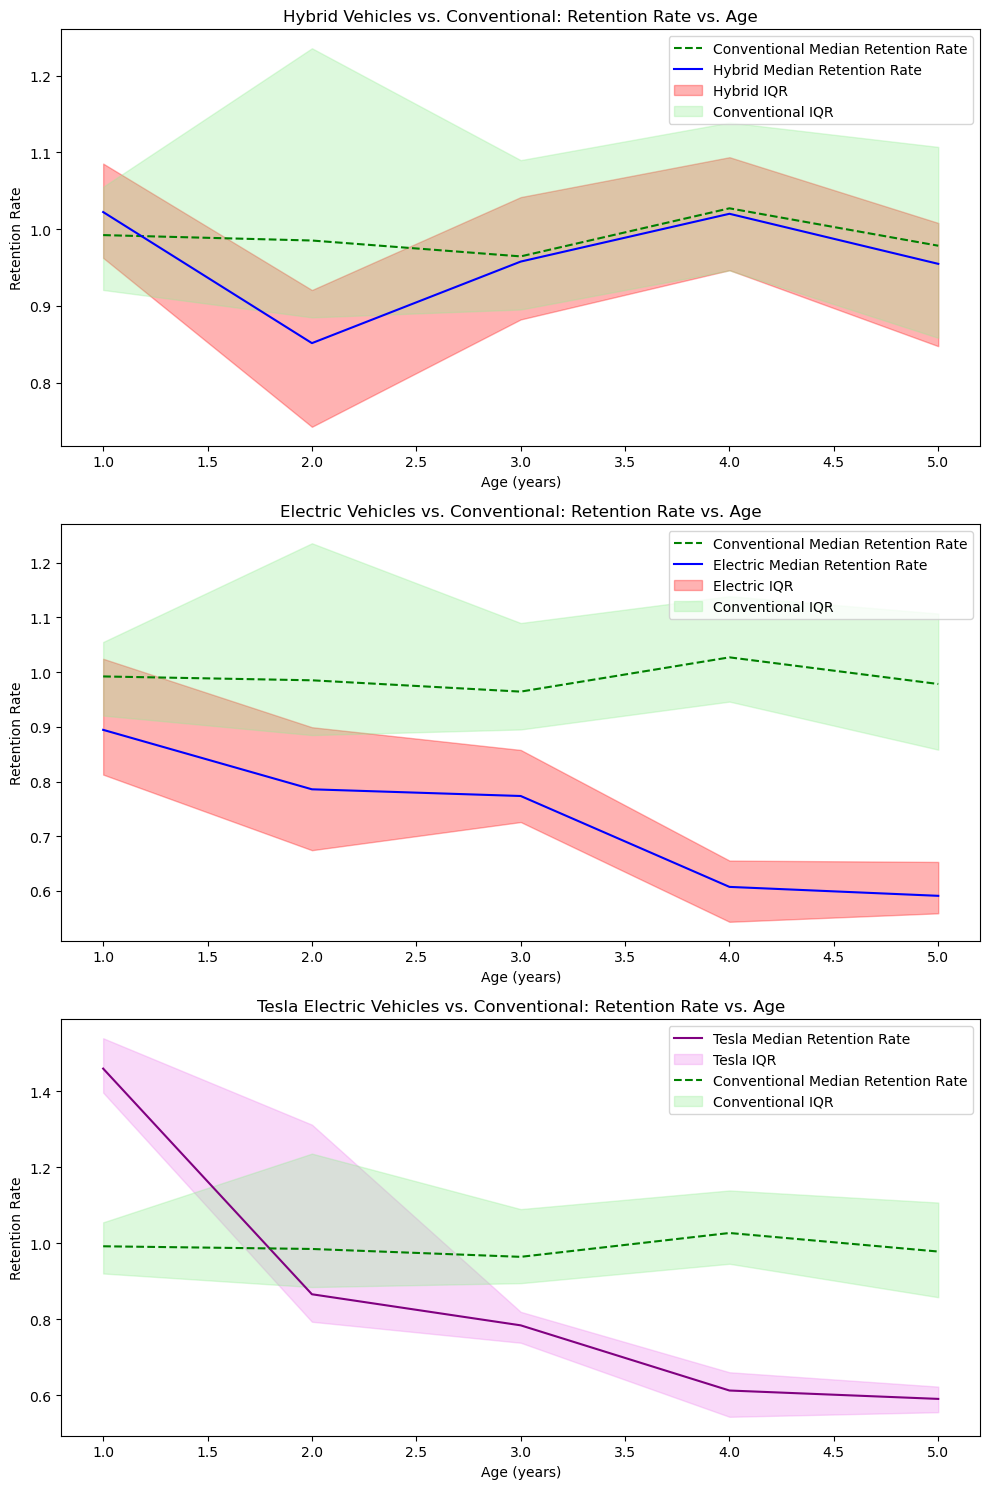

In [3]:
# Filter data for Tesla electric cars
tesla_data = merged_data[(merged_data['Fuel Type Adjusted'] == 'Electric') & (merged_data['Make'] == 'Tesla')]

# Group data by 'Fuel Type Adjusted' and 'Age', then calculate the median and percentiles for each group
grouped_data = merged_data.groupby(['Fuel Type Adjusted', 'Age']).agg(
    median_retention=('Retention Rate', 'median'),
    percentile_25=('Retention Rate', lambda x: np.percentile(x, 25)),
    percentile_75=('Retention Rate', lambda x: np.percentile(x, 75))
).reset_index()

# Group data specifically for Tesla electric cars
grouped_tesla_data = tesla_data.groupby('Age').agg(
    median_retention=('Retention Rate', 'median'),
    percentile_25=('Retention Rate', lambda x: np.percentile(x, 25)),
    percentile_75=('Retention Rate', lambda x: np.percentile(x, 75))
).reset_index()

# Begin plotting the updated version
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # Added one more subplot for Tesla cars

# Plot each fuel type in different subplots
fuel_types = ['Hybrid', 'Electric']  # Specify which fuel types to plot separately
conventional_data = grouped_data[grouped_data['Fuel Type Adjusted'] == 'Conventional']

for index, fuel_type in enumerate(fuel_types):
    subset = grouped_data[grouped_data['Fuel Type Adjusted'] == fuel_type]
    if subset.empty:
        continue

    # Sorting the subsets by 'Age'
    subset = subset.sort_values(by='Age')
    conventional_subset = conventional_data.sort_values(by='Age')

    # Plotting the conventional data on each subplot with a specific color
    axs[index].plot(conventional_subset['Age'], conventional_subset['median_retention'], color='green', label='Conventional Median Retention Rate', linestyle='--')

    # Plotting the specific fuel type data
    axs[index].plot(subset['Age'], subset['median_retention'], color='blue', label=f'{fuel_type} Median Retention Rate')

    # Plotting the area between the 25th and 75th percentiles for each type
    axs[index].fill_between(subset['Age'], subset['percentile_25'], subset['percentile_75'], color='red', alpha=0.3, label=f'{fuel_type} IQR')
    axs[index].fill_between(conventional_subset['Age'], conventional_subset['percentile_25'], conventional_subset['percentile_75'], color='lightgreen', alpha=0.3, label='Conventional IQR')

    axs[index].set_title(f'{fuel_type} Vehicles vs. Conventional: Retention Rate vs. Age')
    axs[index].set_xlabel('Age (years)')
    axs[index].set_ylabel('Retention Rate')

    axs[index].legend()

# Plot Tesla Electric Cars with Conventional Overlay
if not grouped_tesla_data.empty:
    # Sorting Tesla and conventional subsets by 'Age'
    grouped_tesla_data = grouped_tesla_data.sort_values(by='Age')
    conventional_subset = conventional_data.sort_values(by='Age')
    
    # Plotting Tesla data
    axs[2].plot(grouped_tesla_data['Age'], grouped_tesla_data['median_retention'], color='purple', label='Tesla Median Retention Rate')
    axs[2].fill_between(grouped_tesla_data['Age'], grouped_tesla_data['percentile_25'], grouped_tesla_data['percentile_75'], color='violet', alpha=0.3, label='Tesla IQR')

    # Overlaying conventional data
    axs[2].plot(conventional_subset['Age'], conventional_subset['median_retention'], color='green', linestyle='--', label='Conventional Median Retention Rate')
    axs[2].fill_between(conventional_subset['Age'], conventional_subset['percentile_25'], conventional_subset['percentile_75'], color='lightgreen', alpha=0.3, label='Conventional IQR')

    axs[2].set_title('Tesla Electric Vehicles vs. Conventional: Retention Rate vs. Age')
    axs[2].set_xlabel('Age (years)')
    axs[2].set_ylabel('Retention Rate')

    axs[2].legend()

plt.tight_layout()
plt.show()


Conventional Linear Regression:
  Gradient: -0.0011
  Intercept: 1.0333
  R^2: 0.0000
  P-value: 8.6756e-01

Hybrid Linear Regression:
  Gradient: -0.0092
  Intercept: 1.0090
  R^2: 0.0076
  P-value: 1.9836e-02

Electric Linear Regression:
  Gradient: -0.0880
  Intercept: 1.0341
  R^2: 0.2604
  P-value: 2.4500e-52

Tesla Linear Regression:
  Gradient: -0.2053
  Intercept: 1.4806
  R^2: 0.6007
  P-value: 6.0361e-48



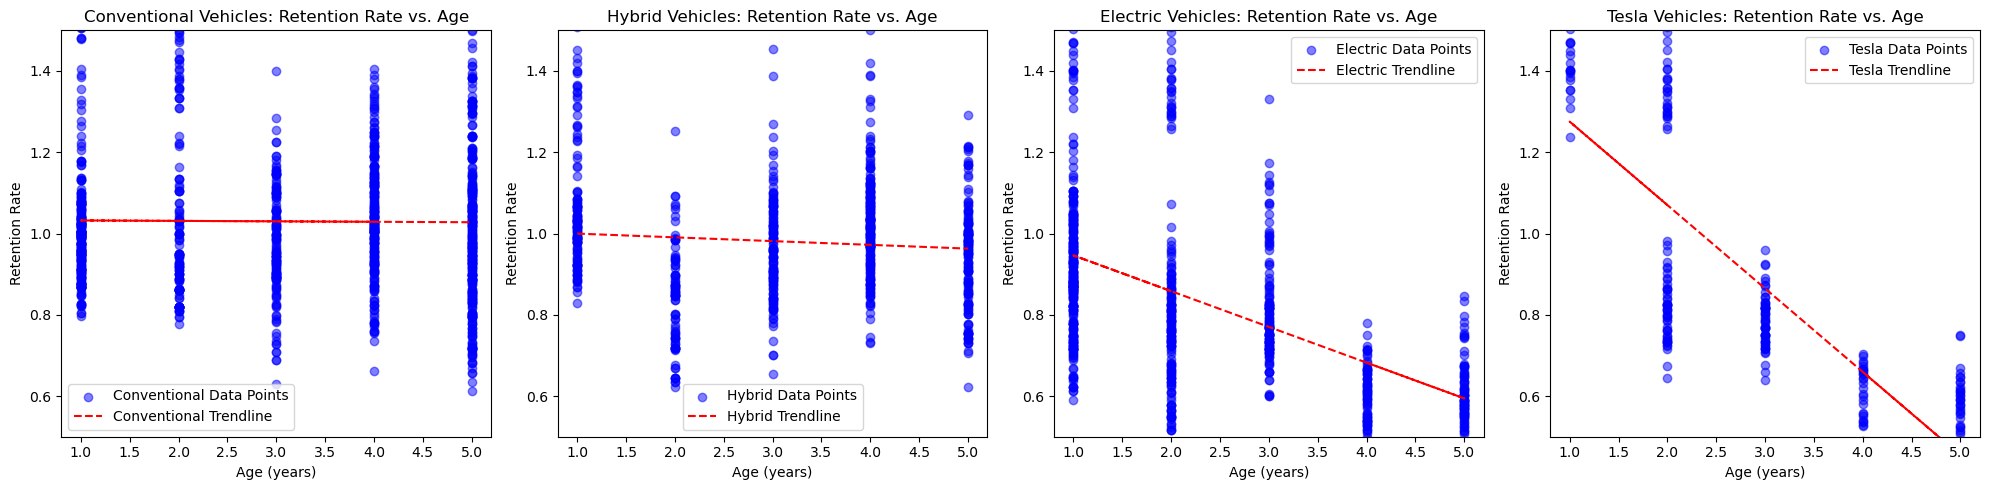

In [4]:
from scipy.stats import linregress

# Filter data for Tesla electric cars
tesla_data = merged_data[(merged_data['Fuel Type Adjusted'] == 'Electric') & (merged_data['Make'] == 'Tesla')]

# Define the fuel types and filter the data accordingly
fuel_types = ['Conventional', 'Hybrid', 'Electric']
filtered_data = merged_data[merged_data['Fuel Type Adjusted'].isin(fuel_types)]

# Begin plotting the updated version
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns for subplots

# Function to plot scatter and trendline
def plot_scatter_with_trendline(ax, x, y, label, color):
    ax.scatter(x, y, alpha=0.5, label=f'{label} Data Points', color=color)
    
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value**2
    
    # Plot the linear regression line
    ax.plot(x, intercept + slope * x, color='red', linestyle='--', label=f'{label} Trendline')
    
    ax.set_ylim(0.5, 1.5)  # Set the y-axis range
    ax.set_title(f'{label} Vehicles: Retention Rate vs. Age')
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Retention Rate')
    ax.legend()
    
    # Print out the statistics
    print(f"{label} Linear Regression:")
    print(f"  Gradient: {slope:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R^2: {r_squared:.4f}")
    print(f"  P-value: {p_value:.4e}\n")

# Plot each fuel type in different subplots
for index, fuel_type in enumerate(fuel_types):
    subset = filtered_data[filtered_data['Fuel Type Adjusted'] == fuel_type]

    # Plot scatter with trendline
    plot_scatter_with_trendline(axs[index], subset['Age'], subset['Retention Rate'], fuel_type, 'blue')

# Plot Tesla Electric Cars
if not tesla_data.empty:
    plot_scatter_with_trendline(axs[3], tesla_data['Age'], tesla_data['Retention Rate'], 'Tesla', 'blue')

plt.tight_layout()
plt.show()


Age 1, Conventional: Gradient = -0.0783, Intercept = 1.0378, R^2 = 0.3014, p-value = 3.5030e-22
Age 1, Hybrid: Gradient = 0.0013, Intercept = 1.0117, R^2 = 0.0001, p-value = 9.2696e-01
Age 1, Electric: Gradient = -0.1405, Intercept = 0.9512, R^2 = 0.1383, p-value = 3.0033e-10
Age 2, Conventional: Gradient = 0.0038, Intercept = 1.0550, R^2 = 0.0005, p-value = 7.8512e-01
Age 2, Hybrid: Gradient = -0.0137, Intercept = 0.8951, R^2 = 0.1006, p-value = 2.4631e-03
Age 2, Electric: Gradient = -0.0073, Intercept = 0.7563, R^2 = 0.0067, p-value = 3.2387e-01
Age 3, Conventional: Gradient = -0.0123, Intercept = 1.0424, R^2 = 0.0326, p-value = 2.3674e-02
Age 3, Hybrid: Gradient = -0.0237, Intercept = 1.0798, R^2 = 0.1679, p-value = 8.0314e-07
Age 3, Electric: Gradient = -0.0208, Intercept = 0.8403, R^2 = 0.1433, p-value = 1.3443e-05
Age 4, Conventional: Gradient = -0.0054, Intercept = 1.0785, R^2 = 0.0335, p-value = 4.3663e-03
Age 4, Hybrid: Gradient = -0.0151, Intercept = 1.1073, R^2 = 0.1392, p-v

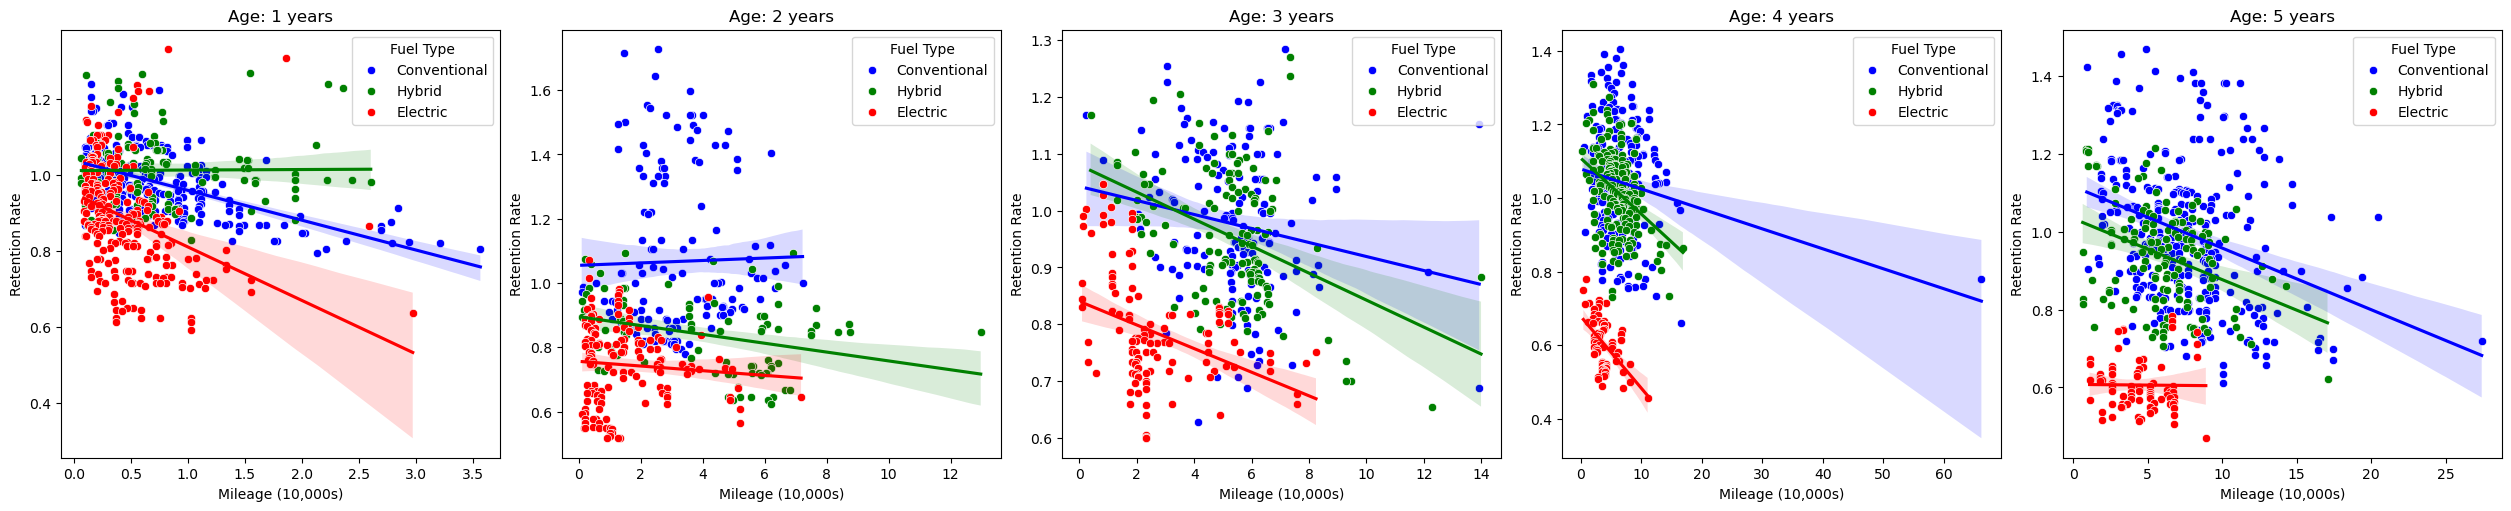

In [5]:
import seaborn as sns

# Get the unique ages in the dataset
unique_ages = sorted(merged_data['Age'].unique())

# Create a figure with subplots in a single row
fig, axs = plt.subplots(1, len(unique_ages), figsize=(5 * len(unique_ages), 5), constrained_layout=True)

# Ensure axs is always iterable, even if there's only one subplot
if len(unique_ages) == 1:
    axs = [axs]

# Define the fuel types
fuel_types = ['Conventional', 'Hybrid', 'Electric']

# Colors for different fuel types
colors = ['blue', 'green', 'red']

# Iterate through each age and create a plot for each fuel type
for ax, age in zip(axs, unique_ages):
    age_data = merged_data[merged_data['Age'] == age]
    for fuel_type, color in zip(fuel_types, colors):
        # Filter data for each fuel type
        fuel_data = age_data[age_data['Fuel Type Adjusted'] == fuel_type]

        # Remove outliers
        q1 = fuel_data['Retention Rate'].quantile(0.25)
        q3 = fuel_data['Retention Rate'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        fuel_data = fuel_data[(fuel_data['Retention Rate'] >= lower_bound) & (fuel_data['Retention Rate'] <= upper_bound)]

        # Scatter plot with mileage divided by 10,000
        sns.scatterplot(data=fuel_data, x=fuel_data['Mileage'] / 10000, y='Retention Rate', ax=ax, color=color, label=fuel_type)
        # Regression line
        sns.regplot(data=fuel_data, x=fuel_data['Mileage'] / 10000, y='Retention Rate', ax=ax, color=color, scatter=False)

        # Linear regression statistics
        if len(fuel_data) > 1:  # Ensure there are enough data points
            slope, intercept, r_value, p_value, std_err = linregress(fuel_data['Mileage'] / 10000, fuel_data['Retention Rate'])
            r_squared = r_value**2
            print(f"Age {age}, {fuel_type}: Gradient = {slope:.4f}, Intercept = {intercept:.4f}, R^2 = {r_squared:.4f}, p-value = {p_value:.4e}")

    ax.set_title(f'Age: {age} years')
    ax.set_xlabel('Mileage (10,000s)')
    ax.set_ylabel('Retention Rate')
    ax.legend(title='Fuel Type')

# Display the plots
plt.show()


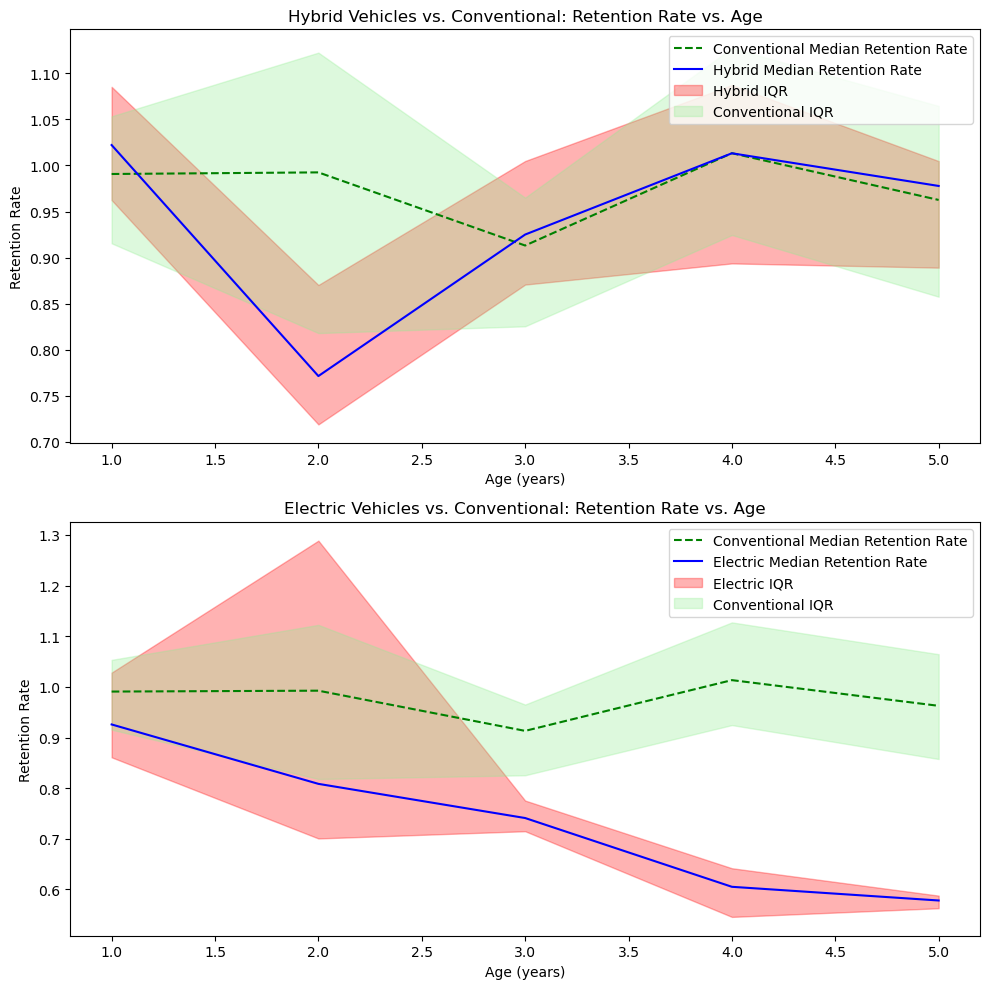

In [6]:
# Get SUV data
suv_data = merged_data[merged_data['Car Type'].str.lower().str.contains('suv')]

# Group data by 'Fuel Type Adjusted' and 'Age', then calculate the median and percentiles for each group
grouped_data = suv_data.groupby(['Fuel Type Adjusted', 'Age']).agg(
    median_retention=('Retention Rate', 'median'),
    percentile_25=('Retention Rate', lambda x: np.percentile(x, 25)),
    percentile_75=('Retention Rate', lambda x: np.percentile(x, 75))
).reset_index()

# Begin plotting the updated version
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # Reduced number of subplots

# Plot each fuel type in different subplots
fuel_types = ['Hybrid', 'Electric']  # Specify which fuel types to plot separately
conventional_data = grouped_data[grouped_data['Fuel Type Adjusted'] == 'Conventional']

for index, fuel_type in enumerate(fuel_types):
    subset = grouped_data[grouped_data['Fuel Type Adjusted'] == fuel_type]
    if subset.empty:
        continue

    # Sorting the subsets by 'Age'
    subset = subset.sort_values(by='Age')
    conventional_subset = conventional_data.sort_values(by='Age')

    # Plotting the conventional data on each subplot with a specific color
    axs[index].plot(conventional_subset['Age'], conventional_subset['median_retention'], color='green', label='Conventional Median Retention Rate', linestyle='--')

    # Plotting the specific fuel type data
    axs[index].plot(subset['Age'], subset['median_retention'], color='blue', label=f'{fuel_type} Median Retention Rate')

    # Plotting the area between the 25th and 75th percentiles for each type
    axs[index].fill_between(subset['Age'], subset['percentile_25'], subset['percentile_75'], color='red', alpha=0.3, label=f'{fuel_type} IQR')
    axs[index].fill_between(conventional_subset['Age'], conventional_subset['percentile_25'], conventional_subset['percentile_75'], color='lightgreen', alpha=0.3, label='Conventional IQR')

    axs[index].set_title(f'{fuel_type} Vehicles vs. Conventional: Retention Rate vs. Age')
    axs[index].set_xlabel('Age (years)')
    axs[index].set_ylabel('Retention Rate')

    axs[index].legend()

plt.tight_layout()
plt.show()


Conventional Linear Regression:
  Gradient: -0.0016
  Intercept: 1.0179
  R^2: 0.0000
  P-value: 8.6573e-01

Hybrid Linear Regression:
  Gradient: -0.0134
  Intercept: 1.0152
  R^2: 0.0178
  P-value: 5.9922e-03

Electric Linear Regression:
  Gradient: -0.1171
  Intercept: 1.1225
  R^2: 0.2898
  P-value: 8.9448e-33

Tesla Linear Regression:
  Gradient: -0.0820
  Intercept: 1.5454
  R^2: 0.1331
  P-value: 4.1533e-03



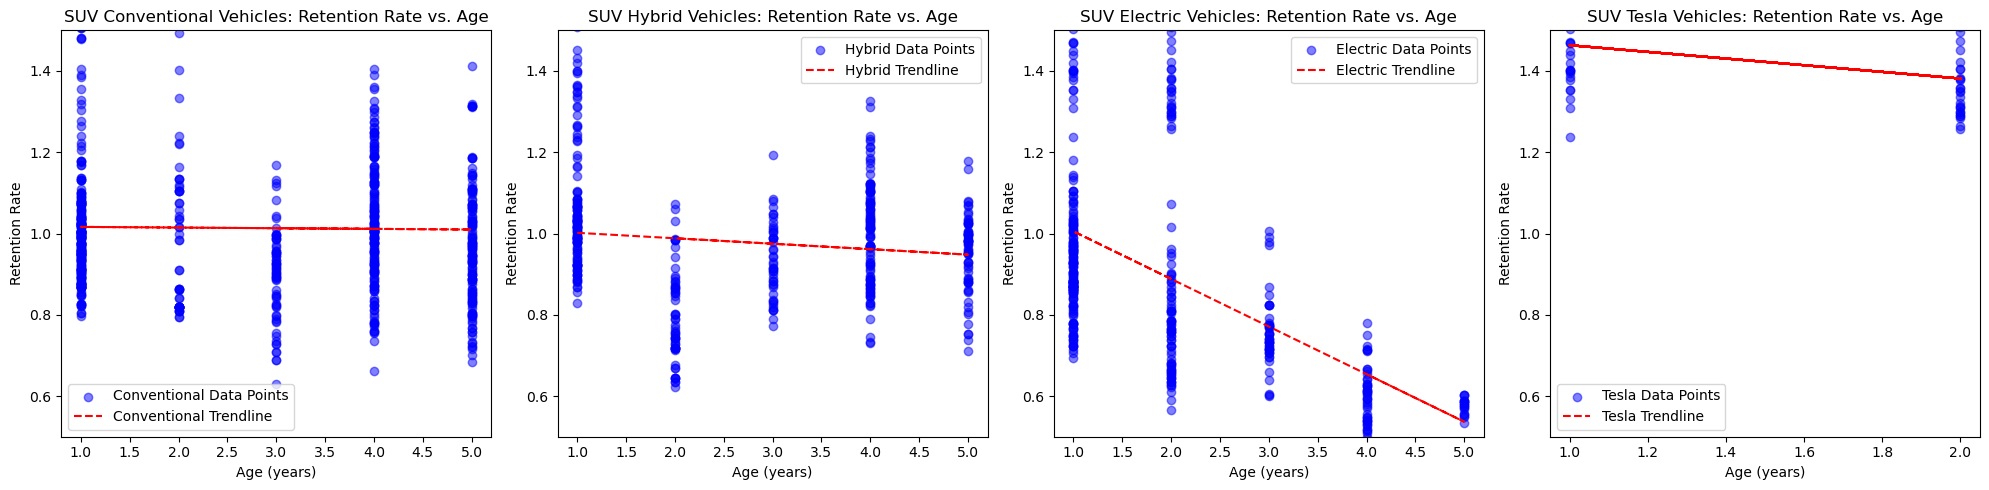

In [7]:
# Filter data for Tesla electric cars
tesla_data = suv_data[(suv_data['Fuel Type Adjusted'] == 'Electric') & (suv_data['Make'] == 'Tesla')]

# Define the fuel types and filter the data accordingly
fuel_types = ['Conventional', 'Hybrid', 'Electric']
filtered_data = suv_data[suv_data['Fuel Type Adjusted'].isin(fuel_types)]

# Begin plotting the updated version
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row, 4 columns for subplots

# Function to plot scatter and trendline
def plot_scatter_with_trendline(ax, x, y, label, color):
    ax.scatter(x, y, alpha=0.5, label=f'{label} Data Points', color=color)
    
    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value**2
    
    # Plot the linear regression line
    ax.plot(x, intercept + slope * x, color='red', linestyle='--', label=f'{label} Trendline')
    
    ax.set_ylim(0.5, 1.5)  # Set the y-axis range
    ax.set_title(f'SUV {label} Vehicles: Retention Rate vs. Age')
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Retention Rate')
    ax.legend()
    
    # Print out the statistics
    print(f"{label} Linear Regression:")
    print(f"  Gradient: {slope:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  R^2: {r_squared:.4f}")
    print(f"  P-value: {p_value:.4e}\n")

# Plot each fuel type in different subplots
for index, fuel_type in enumerate(fuel_types):
    subset = filtered_data[filtered_data['Fuel Type Adjusted'] == fuel_type]

    # Plot scatter with trendline
    plot_scatter_with_trendline(axs[index], subset['Age'], subset['Retention Rate'], fuel_type, 'blue')

# Plot Tesla Electric Cars
if not tesla_data.empty:
    plot_scatter_with_trendline(axs[3], tesla_data['Age'], tesla_data['Retention Rate'], 'Tesla', 'blue')

plt.tight_layout()
plt.show()


Age 1, Conventional: Gradient = -0.0780, Intercept = 1.0369, R^2 = 0.2991, p-value = 3.2330e-21
Age 1, Hybrid: Gradient = 0.0013, Intercept = 1.0117, R^2 = 0.0001, p-value = 9.2696e-01
Age 1, Electric: Gradient = -0.1535, Intercept = 0.9691, R^2 = 0.2623, p-value = 1.1036e-12
Age 2, Conventional: Gradient = 0.0293, Intercept = 0.8998, R^2 = 0.0548, p-value = 7.9556e-02
Age 2, Hybrid: Gradient = -0.0376, Intercept = 0.9219, R^2 = 0.5944, p-value = 5.7652e-13
Age 2, Electric: Gradient = 0.0689, Intercept = 0.8414, R^2 = 0.0737, p-value = 5.3113e-03
Age 3, Conventional: Gradient = -0.0254, Intercept = 1.0397, R^2 = 0.1434, p-value = 1.2292e-03
Age 3, Hybrid: Gradient = -0.0242, Intercept = 1.0439, R^2 = 0.3724, p-value = 5.2527e-06
Age 3, Electric: Gradient = -0.0308, Intercept = 0.8015, R^2 = 0.1228, p-value = 2.4712e-02
Age 4, Conventional: Gradient = -0.0069, Intercept = 1.0684, R^2 = 0.0580, p-value = 1.0967e-03
Age 4, Hybrid: Gradient = -0.0167, Intercept = 1.1106, R^2 = 0.1520, p-va

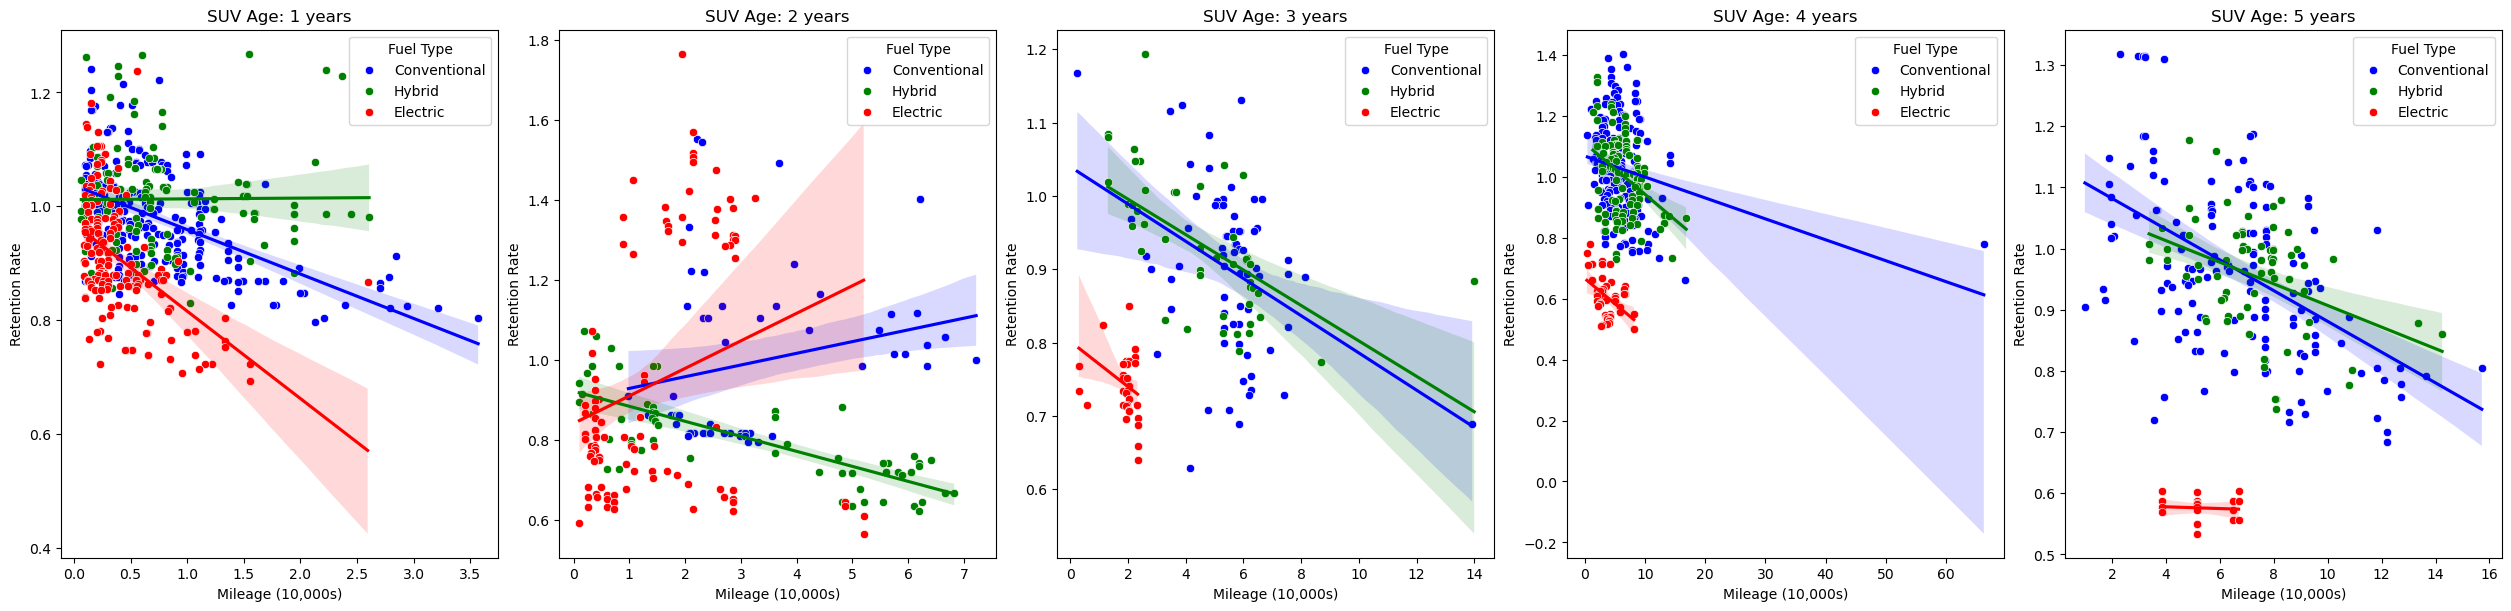

In [8]:
# Repeat for SUV data

# Get the unique ages in the dataset
unique_ages = sorted(suv_data['Age'].unique())

# Create a figure with subplots in a single horizontal row
fig, axs = plt.subplots(1, len(unique_ages), figsize=(5 * len(unique_ages), 6), constrained_layout=True)

# Ensure axs is always iterable, even if there's only one subplot
if len(unique_ages) == 1:
    axs = [axs]

# Define the fuel types
fuel_types = ['Conventional', 'Hybrid', 'Electric']

# Colors for different fuel types
colors = ['blue', 'green', 'red']

# Iterate through each age and create a plot for each fuel type
for ax, age in zip(axs, unique_ages):
    age_data = suv_data[suv_data['Age'] == age]
    for fuel_type, color in zip(fuel_types, colors):
        # Filter data for each fuel type
        fuel_data = age_data[age_data['Fuel Type Adjusted'] == fuel_type]

        # Remove outliers
        q1 = fuel_data['Retention Rate'].quantile(0.25)
        q3 = fuel_data['Retention Rate'].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        fuel_data = fuel_data[(fuel_data['Retention Rate'] >= lower_bound) & (fuel_data['Retention Rate'] <= upper_bound)]

        # Scatter plot with mileage divided by 10,000
        sns.scatterplot(data=fuel_data, x=fuel_data['Mileage'] / 10000, y='Retention Rate', ax=ax, color=color, label=fuel_type)
        # Regression line
        sns.regplot(data=fuel_data, x=fuel_data['Mileage'] / 10000, y='Retention Rate', ax=ax, color=color, scatter=False)

        # Linear regression statistics
        if len(fuel_data) > 1:  # Ensure there are enough data points
            slope, intercept, r_value, p_value, std_err = linregress(fuel_data['Mileage'] / 10000, fuel_data['Retention Rate'])
            r_squared = r_value**2
            print(f"Age {age}, {fuel_type}: Gradient = {slope:.4f}, Intercept = {intercept:.4f}, R^2 = {r_squared:.4f}, p-value = {p_value:.4e}")

    ax.set_title(f'SUV Age: {age} years')
    ax.set_xlabel('Mileage (10,000s)')
    ax.set_ylabel('Retention Rate')
    ax.legend(title='Fuel Type')

# Display the plots
plt.show()
